# Practice Lab 18: Convolutional Neural Networks
In this lab we will look at how Convolutional Neural Networks for classification and regression. \
Based on Chapter 14 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice18a_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Add for GPU BEFORE JSON
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
####################################

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Added two functions for plotting

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Exercise 1: CNN dimensions
In this first exercise we want to get familiar with dimensions.\
Load the two images below and apply a vertical and a horizontal filter.\
Check all dimensions. Then plot one row of one of the figures before and after convolutions. \
Show how the convolution with the horizontal filter produces a smoothing along the rows.

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
print("batch_size, height, width, channels",images.shape)
batch_size, height, width, channels = images.shape
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
print(filters.shape)

batch_size, height, width, channels (2, 427, 640, 3)
(7, 7, 3, 2)


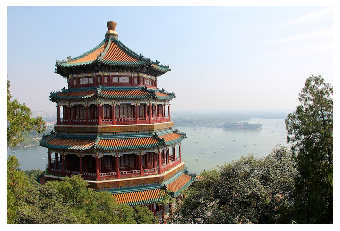

In [4]:
plot_image(china)

In [5]:
print(china.shape)

(427, 640, 3)


In [6]:
print(flower.shape)

(427, 640, 3)


Text(0.5, 1.0, 'column')

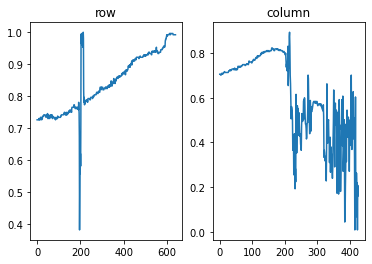

In [7]:
# show a row and a column of the original picture
plt.subplot(121);plt.plot(china[50,:,0]);plt.title('row')
plt.subplot(122);plt.plot(china[:,50,0]);plt.title('column')

In [8]:
print(images.shape)

(2, 427, 640, 3)


In [9]:
print(filters.shape)

(7, 7, 3, 2)


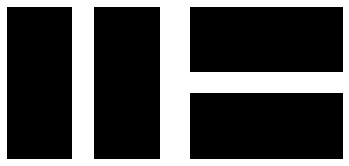

In [10]:
plt.subplot(121);plot_image(filters[:,:,:,0])
plt.subplot(122);plot_image(filters[:,:,:,1])

We can perform the correlations using conv2d. We see 3 input features map to 2 output features because we have 2 filters. \
What do these operations represent? What does multiplication by a boxcar represent?

In [11]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

In [12]:
print(outputs.shape)

(2, 427, 640, 2)


In [13]:
print(images.shape)

(2, 427, 640, 3)


In [14]:
print(filters.shape)

(7, 7, 3, 2)


What do we get if we print index 0 and 1 in the first index?\
What do we get if we print index 0 and 1 in the last index?

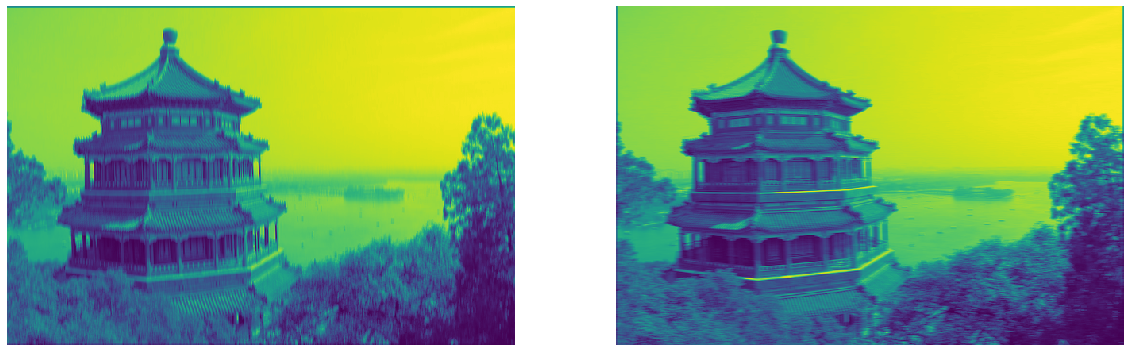

In [15]:
plt.figure(figsize=(20,20))
plt.subplot(121),plot_color_image(outputs[0,:,:,0])
plt.subplot(122),plot_color_image(outputs[0,:,:,1]);

What do we get if we choose one index on the second or third indexes?

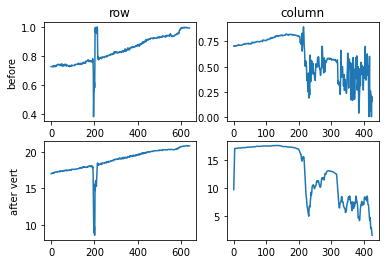

In [16]:
# plot a row and a column before and after the vertical filter
plt.subplot(221);plt.plot(images[0,50,:,0]);plt.title('row');plt.ylabel('before')
plt.subplot(222);plt.plot(images[0,:,50,0]);plt.title('column')
plt.subplot(223);plt.plot(outputs[0,50,:,0]);plt.ylabel('after vert')
plt.subplot(224);plt.plot(outputs[0,:,50,0]);

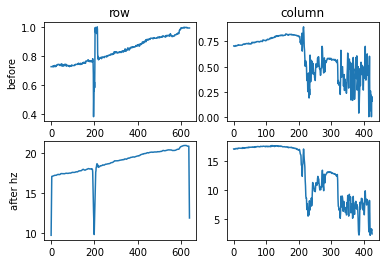

In [17]:
# plot a row and a column after the horizontal filter

plt.subplot(221);plt.plot(images[0,50,:,0]);plt.title('row');plt.ylabel('before')
plt.subplot(222);plt.plot(images[0,:,50,0]);plt.title('column')
plt.subplot(223);plt.plot(outputs[0,50,:,1]);plt.ylabel('after hz')
plt.subplot(224);plt.plot(outputs[0,:,50,1])

Let us see the input (3 layers R, G, B)

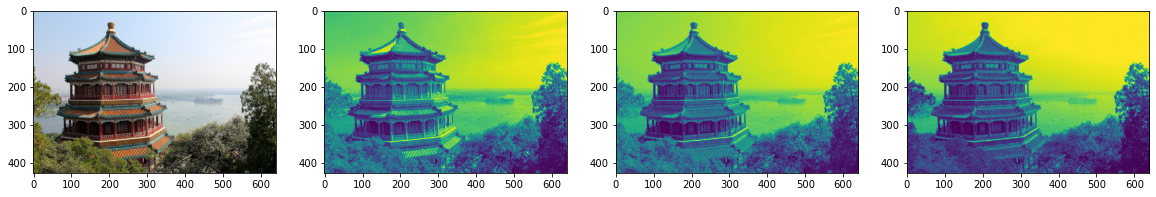

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(141),plt.imshow(images[0])
for i in range(3):    
    plt.subplot(142+i);plt.imshow(china[:,:,i]);

Let us see the output (2 feature maps)

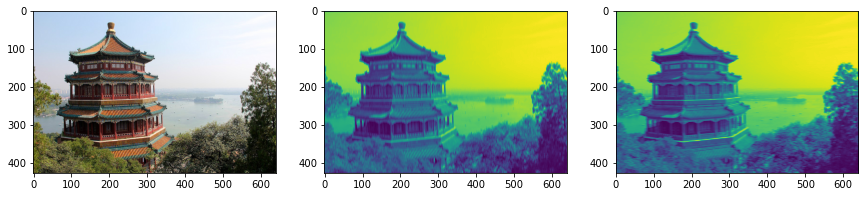

In [19]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.figure(figsize=(20,20))
plt.subplot(141),plt.imshow(images[0])
for i in range(2):    
    plt.subplot(142+i);plt.imshow(outputs[0,:,:,i]);

Applying a pooling layer reduces the dimensions. This allows us to look at patterns with different resolution.

<class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
(2, 427, 640, 2)
(2, 53, 80, 2)


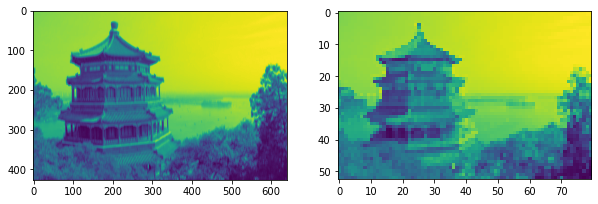

In [20]:
max_pool = keras.layers.MaxPool2D(pool_size=8)
outputspool=max_pool(outputs)
print(type(max_pool))
print(outputs.shape)
print(outputspool.shape)
plt.figure(figsize=(10,10))
plt.subplot(121);plt.imshow(outputs[0,:,:,0])
plt.subplot(122);plt.imshow(outputspool[0,:,:,0]);

## Exercise 2: CNN vs Dense NN
MNIST Classification: Write conv2d for the mnist data set and compare with the 1D neural network we did in a previous lab.\
To treat each digit as an image, you need to add the feature axis, 1 in this case because it is black-white image.

In [21]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
# we will need a new axis to represent the channel index (one in this case)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [22]:
print(X_train.shape)

(55000, 28, 28, 1)


In [23]:
print(X_valid.shape)
print(X_test.shape)

(5000, 28, 28, 1)
(10000, 28, 28, 1)


Let us write a first CNN using the tools we learned above. Notice that each layer needs:
- Number of features (these are like neurons, like Dense NN)
- A kernel_size
- Activation function (like Dense NN)
- Padding strategy
- Pooling layer

Also, notice that:
- after the CNN there will be a **second stage** with a **dense NN**.
- The number of features in the CNN increases as the resolution decreases, 
- The number of neurons in the DNN decreases as we approach the output.

In [24]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=(7,7), activation='relu', padding='SAME',input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=(5,5), activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')    
])

Alternatively, for long stacks of layers, we can create a default so we don't need to repeat parameters

In [25]:
#create a default layer to avoid repeating
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu',padding='SAME')

In [26]:
model=keras.models.Sequential([
    DefaultConv2D(64, kernel_size=(7,7), input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(),
    DefaultConv2D(128, kernel_size=(5,5)),
    keras.layers.MaxPooling2D(),
    DefaultConv2D(256),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')    
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

Compilation and training is done in the same way as Dense NN

In [28]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=["accuracy"])

In [29]:
history=model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.4407 - accuracy: 0.5088 - val_loss: 0.1012 - val_accuracy: 0.9708
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2716 - accuracy: 0.9222 - val_loss: 0.0653 - val_accuracy: 0.9822
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1765 - accuracy: 0.9531 - val_loss: 0.0528 - val_accuracy: 0.9866
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1306 - accuracy: 0.9655 - val_loss: 0.0520 - val_accuracy: 0.9876
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1105 - accuracy: 0.9718 - val_loss: 0.0440 - val_accuracy: 0.9882
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0903 - accuracy: 0.9767 - val_loss: 0.0452 - val_accuracy: 0.9902
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0778 - accuracy: 0.9787 - val_loss: 0.0415 - val_accuracy:

In [30]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0293 - accuracy: 0.9914


[0.029340224340558052, 0.9914000034332275]

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

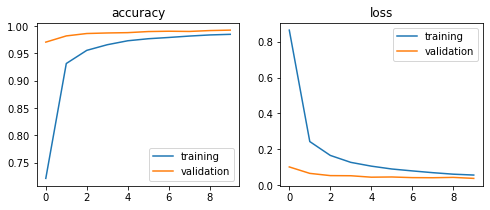

In [32]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history.history['accuracy'],label='training');plt.plot(history.history['val_accuracy'],label='validation');plt.title('accuracy')
plt.legend()
plt.subplot(122),plt.plot(history.history['loss'],label='training');plt.plot(history.history['val_loss'],label='validation');plt.title('loss')
plt.legend()

### CNN vs Dense network (FCN)
Now let us compare with the dense network we have been doing before

In [33]:
model1d = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model1d.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
model1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [35]:
print(X_train[:,:,:,0].shape)
print(y_train.shape)

(55000, 28, 28)
(55000,)


In [36]:
history1d=model1d.fit(X_train[:,:,:,0],y_train,epochs=10,validation_data=(X_valid[:,:,:,0],y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.6352 - accuracy: 0.5004 - val_loss: 0.5863 - val_accuracy: 0.8546
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5741 - accuracy: 0.8446 - val_loss: 0.3899 - val_accuracy: 0.8980
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4130 - accuracy: 0.8845 - val_loss: 0.3182 - val_accuracy: 0.9154
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3469 - accuracy: 0.9010 - val_loss: 0.2806 - val_accuracy: 0.9260
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3031 - accuracy: 0.9125 - val_loss: 0.2557 - val_accuracy: 0.9328
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2805 - accuracy: 0.9176 - val_loss: 0.2375 - val_accuracy: 0.9386
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2534 - accuracy: 0.9255 - val_loss: 0.2242 - val_accuracy:

In [37]:
model1d.evaluate(X_test[:,:,:,0],y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1242.1067 - accuracy: 0.9344


[1242.106689453125, 0.9344000220298767]

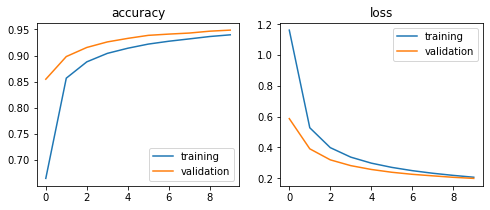

In [38]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history1d.history['accuracy'],label='training');plt.plot(history1d.history['val_accuracy'],label='validation');plt.title('accuracy')
plt.legend()
plt.subplot(122),plt.plot(history1d.history['loss'],label='training');plt.plot(history1d.history['val_loss'],label='validation');plt.title('loss')
plt.legend();

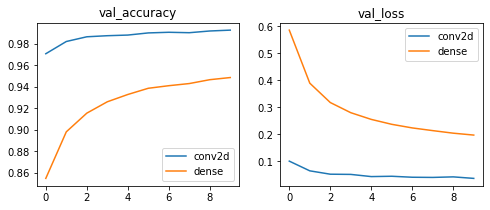

In [39]:
plt.figure(figsize=(8,3))
plt.subplot(121),plt.plot(history.history['val_accuracy'],label='conv2d');plt.plot(history1d.history['val_accuracy'],label='dense');plt.title('val_accuracy')
plt.legend()
plt.subplot(122),plt.plot(history.history['val_loss'],label='conv2d');plt.plot(history1d.history['val_loss'],label='dense');plt.title('val_loss')
plt.legend();

In [40]:
ntest=20;
y_predict2d=model.predict(X_test[:ntest])

In [41]:
y_predict1d=model1d.predict(X_test[:ntest,:,:,0])

In [42]:
print(y_test[:ntest])

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [43]:
print(y_predict2d.shape)

(20, 10)


In [44]:
print(y_predict1d.shape)

(20, 10)


In [45]:
print(['index','true','pred2d','pred1d'])
[print(i,'\t',y_test[i], '\t',y_predict2d[i,:].argmax(), '\t',y_predict1d[i,:].argmax()) for i in range(0,ntest)];

['index', 'true', 'pred2d', 'pred1d']
0 	 7 	 7 	 7
1 	 2 	 2 	 2
2 	 1 	 1 	 1
3 	 0 	 0 	 0
4 	 4 	 4 	 4
5 	 1 	 1 	 1
6 	 4 	 4 	 4
7 	 9 	 9 	 9
8 	 5 	 5 	 6
9 	 9 	 9 	 9
10 	 0 	 0 	 0
11 	 6 	 6 	 6
12 	 9 	 9 	 9
13 	 0 	 0 	 0
14 	 1 	 1 	 1
15 	 5 	 5 	 5
16 	 9 	 9 	 9
17 	 7 	 7 	 7
18 	 3 	 3 	 3
19 	 4 	 4 	 4


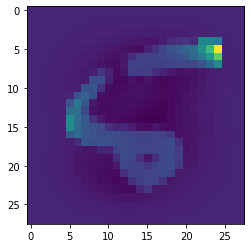

In [46]:
[plt.imshow(X_test[8,:,:,0]) for i in range(0,10)];

## Exercise 3: Fashion data set
This is similar to MNIST in size but harder to classify right.

In [47]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [48]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28, 1) (55000,)
(5000, 28, 28, 1) (5000,)
(10000, 28, 28, 1) (10000,)


In [49]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [51]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

### Filter sizes
For each layer, the size of the filters can be calculated as

$\sqrt((param-nfeatures)/nfeatures)$

Subtract nfeatures for the biases (they count as one parameter per feature) and filters are 2D $(nfilter^2)$

Example, below, 
conv2d_3  we have
sqrt((3200-64)/64)=7
conv2d_7, we have
sqrt((590080-256)/256)=48



In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 256)        

In [53]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0098 - accuracy: 0.6429 - val_loss: 0.3774 - val_accuracy: 0.8610
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4284 - accuracy: 0.8530 - val_loss: 0.3194 - val_accuracy: 0.8832
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3574 - accuracy: 0.8800 - val_loss: 0.3335 - val_accuracy: 0.8762
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3194 - accuracy: 0.8895 - val_loss: 0.2772 - val_accuracy: 0.8946
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2977 - accuracy: 0.8976 - val_loss: 0.2801 - val_accuracy: 0.8982
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2766 - accuracy: 0.9035 - val_loss: 0.2723 - val_accuracy: 0.8952
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2608 - accuracy: 0.9090 - val_loss: 0.3066 - val_ac

In [54]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8960


In [55]:
X_new = X_test[:8] # pretend we have new images
y_pred = model.predict(X_new)

In [56]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [57]:
print(y_pred.shape)

(8, 10)


In [58]:
print(class_names[y_pred[0,:].argmax()])

Ankle boot


In [59]:
plt.axes

<function matplotlib.pyplot.axes(arg=None, **kwargs)>

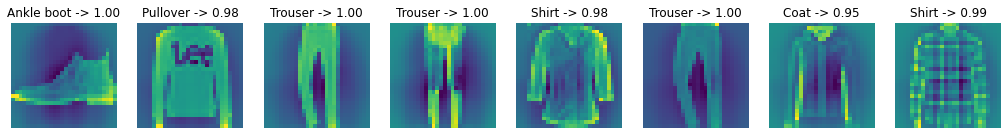

In [60]:
plt.figure(figsize=(20,20))
for i in range(8):    
    plt.subplot(191+i)
    plt.imshow(X_new[i].reshape(28,28));    
    maxp=np.argmax(y_pred[i])
    plt.title('%s -> %.2f'%(class_names[maxp],y_pred[i][maxp]))
    plt.axis("off")

In [70]:
y_pred[:][:9]

array([[3.86659217e-26, 1.70476078e-30, 1.01820999e-33, 6.05273514e-31,
        2.33030980e-37, 1.07283518e-12, 8.99495951e-28, 2.25685035e-05,
        5.79700784e-26, 9.99977469e-01],
       [5.74182595e-05, 2.37784681e-10, 9.78680372e-01, 2.65073510e-08,
        6.14877325e-04, 5.99139173e-16, 2.06474066e-02, 7.57674346e-17,
        2.09565663e-08, 3.13101097e-16],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.19976511e-36,
        0.00000000e+00, 0.00000000e+00, 7.78692228e-35, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 2.40583279e-36,
        0.00000000e+00, 0.00000000e+00, 3.42059271e-35, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.51170800e-02, 2.52342758e-10, 1.81027615e-04, 4.28718113e-06,
        1.08794826e-04, 8.42259811e-16, 9.84588802e-01, 2.77826703e-20,
        8.36875902e-09, 4.56264554e-19],
       [5.50931141e-38, 1.00000000e+00, 0.00000000e+00, 7.03479811e-33,
   